In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# Create engine using the `hawaii.sqlite` database file
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# Declare a Base using `automap_base()`
Base = automap_base()
# Use the Base class to reflect the database tables
Base.prepare(autoload_with=engine)

In [6]:
# Print all of the classes mapped to the Base
Base.classes.keys()

['measurement', 'station']

In [7]:
# Assign the measurement class to a variable called `Measurement` and
# the station class to a variable called `Station`
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create a session
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Display the first row's columns and data in dictionary format - Measurement
first_row_measurement = session.query(Measurement).first()
first_row_measurement.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7fe9d85fe500>,
 'date': '2010-01-01',
 'tobs': 65.0,
 'prcp': 0.08,
 'station': 'USC00519397',
 'id': 1}

In [10]:
# Find the most recent date in the data set.
recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
recent_date

('2017-08-23',)

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.
# Starting from the most recent data point in the database.

# Calculate the date one year from the last date in data set.
query_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
query_date

# Perform a query to retrieve the date and precipitation scores - I decided to keep the station information too
last_year = session.query(Measurement.date, Measurement.station, Measurement.prcp).filter(Measurement.date >= query_date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(last_year)
precipitation_df = precipitation_df.rename(columns={'date': 'Date', 'station': 'Station', 'prcp': 'Precipitation'})

station_group_df = precipitation_df.groupby('Station').count()
station_group_df

,Date,Precipitation
Station,,
USC00513117,343,343
USC00514830,305,265
USC00516128,349,328
USC00517948,183,60
USC00519281,352,352
USC00519397,361,359
USC00519523,337,314


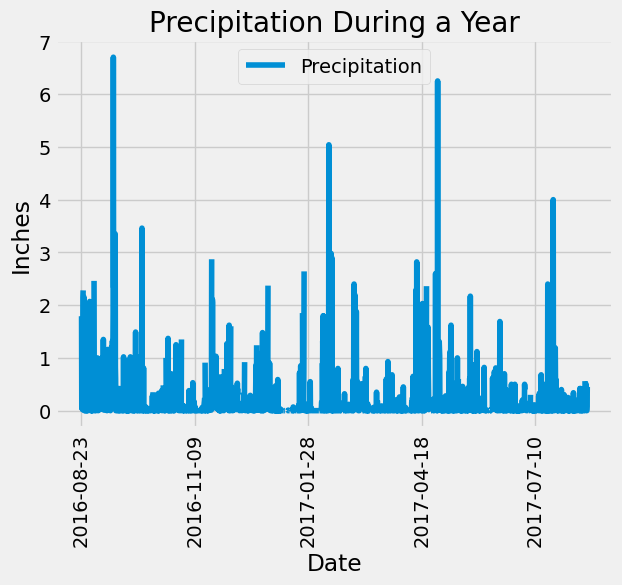

In [12]:
# Sort the dataframe by date
precipitation_sorted_df = precipitation_df.sort_values('Date')
precipitation_sorted_df

# Use Pandas Plotting with Matplotlib to plot the data
precipitation_sorted_df.plot(x='Date', y='Precipitation', title='Precipitation During a Year')
plt.xlabel('Date')
plt.ylabel('Inches')
plt.xticks(rotation=90)
plt.show()

In [13]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_summary = precipitation_sorted_df['Precipitation'].agg(['count','mean', 'std', 'min', lambda x: x.quantile(0.25), 
                                                                      lambda x: x.quantile(0.50), lambda x: x.quantile(0.75), 'max'])

precipitation_summary.index = ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']
precipitation_summary_df = pd.DataFrame(precipitation_summary)
precipitation_summary_df

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [14]:
# Analize the NaN and look for relevant findings - Station USC00517948 has the highest count of NaN and from the 183 records, 123 are NaN!!!!! OMG
filtered_nan_df = precipitation_df[precipitation_df['Precipitation'].isna()]
nan_group_df = filtered_nan_df.groupby('Station').count()
nan_group_df

,Date,Precipitation
Station,,
USC00514830,40,0
USC00516128,21,0
USC00517948,123,0
USC00519397,2,0
USC00519523,23,0


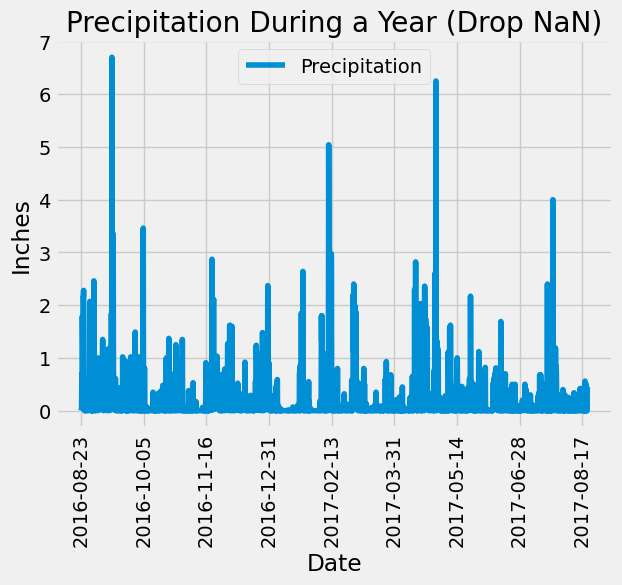

In [16]:
# Drop NaN
precipitation_drop_nan = precipitation_df.dropna(how = 'any')
precipitation_drop_nan
                                                 
# Sort the dataframe by date
precipitation_drop_nan_sorted_df = precipitation_drop_nan.sort_values('Date')
precipitation_drop_nan_sorted_df

# Use Pandas Plotting with Matplotlib to plot the data
precipitation_drop_nan_sorted_df.plot(x='Date', y='Precipitation', title='Precipitation During a Year (Drop NaN)')
plt.xlabel('Date')
plt.ylabel('Inches')
plt.xticks(rotation=90)
plt.show()

In [17]:
# Use Pandas to calculate the summary statistics for the precipitation data on the df with DropNaN
precipitation_nan_summary = precipitation_drop_nan_sorted_df['Precipitation'].agg(['count','mean', 'std', 'min', lambda x: x.quantile(0.25), 
                                                                      lambda x: x.quantile(0.50), lambda x: x.quantile(0.75), 'max'])

precipitation_nan_summary.index = ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']
precipitation_nan_summary_df = pd.DataFrame(precipitation_summary)
precipitation_nan_summary_df

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [18]:
# Display the first row's columns and data in dictionary format - Station
first_row_station = session.query(Station).first()
first_row_station.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7fe9d87b6620>,
 'latitude': 21.2716,
 'id': 1,
 'elevation': 3.0,
 'name': 'WAIKIKI 717.2, HI US',
 'longitude': -157.8168,
 'station': 'USC00519397'}

In [19]:
# Design a query to calculate the total number of stations in the dataset
number_stations = session.query(Station).group_by(Station.station).count()
number_stations

9

In [20]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
stations_activity = session.query(Station.station, func.count(Measurement.station))\
                    .join(Measurement, Station.station == Measurement.station)\
                    .group_by(Measurement.station)\
                    .order_by(func.count(Measurement.station).desc()).all()
for station in stations_activity:
    print(station.station, station[1])

USC00519281 2772
USC00519397 2724
USC00513117 2709
USC00519523 2669
USC00516128 2612
USC00514830 2202
USC00511918 1979
USC00517948 1372
USC00518838 511


In [21]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = 'USC00519281'

mas_temp = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).filter(Measurement.station == most_active_station).all()
mas_temp

[(54.0, 85.0, 71.66378066378067)]

In [22]:
# Find the most recent date for station 'USC00519281'.
mas_recent_date = session.query(Measurement.date).filter(Measurement.station == most_active_station).order_by(Measurement.date.desc()).first()
mas_recent_date

('2017-08-18',)

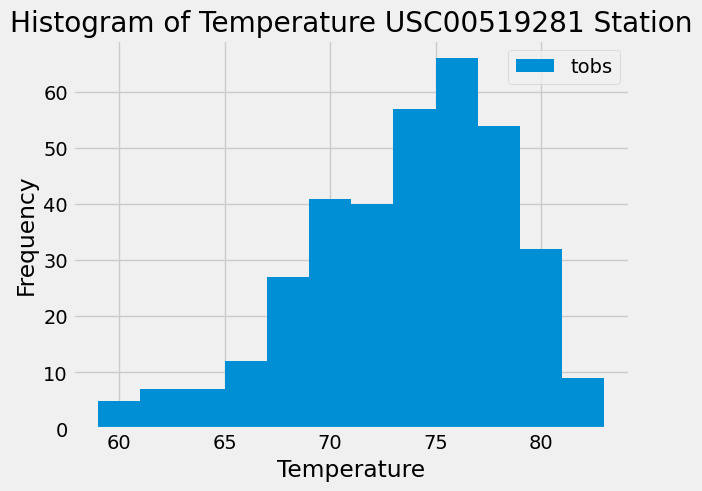

In [23]:
# Using the most active station id
# Calculate the date one year from the last date for station 'USC00519281'.
mas_query_date = dt.date(2017, 8, 18) - dt.timedelta(days=365)
mas_query_date

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
mas_last_year = session.query(Measurement.date, Measurement.tobs).filter(Measurement.station == most_active_station).filter(Measurement.date >= mas_query_date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
temperature_df = pd.DataFrame(mas_last_year)
temperature_df = temperature_df.rename(columns={'date': 'Date', 'tobs': 'Temperature'})
temperature_df

# Use Pandas Plotting with Matplotlib to plot the data
plt.hist(temperature_df['Temperature'], bins=12, label='tobs')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.title('Histogram of Temperature USC00519281 Station')
plt.legend(loc='upper right')
plt.tight_layout
plt.show()

# Close Session

In [24]:
# Close Session
session.close()
